In [105]:
from SimPEG import EM, Mesh, Utils, Maps
from scipy.constants import mu_0
from pymatsolver import MumpsSolver
import cPickle as pickle
from ipywidgets import interact
%pylab inline

Populating the interactive namespace from numpy and matplotlib


TODOs:
- General Waveform
- Current sources both edge (EB form) and face (HJ form)

In [106]:
TKCATEMexample = pickle.load(open( "TKCATEMexample.p", "rb" ))
print TKCATEMexample.keys()

['perc', 'ntx', 'floor', 'dobs_ds', 'xyz', 'xyz_ds', 'times', 'dtrue', 'mesh', 'dobs', 'ntx_ds', 'timeSteps', 'sigma', 'timeSteps_inv']


In [107]:
mesh = TKCATEMexample["mesh"]

In [108]:
from simpegem1d import EM1DAnal
print EM1DAnal.DiffusionDistnace(1e-4, 5e-2)
print EM1DAnal.DiffusionDistnace(2e-3, 1e-4)
print mesh.hx[:npad].sum()

56.4189583548
5641.89583548
4441.93911665


In [109]:
def gettopoCC(mesh, airind):
# def gettopoCC(mesh, airind):
    """
        Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC

In [110]:
sigma = mesh.readModelUBC("./Geomodel/VTKout.dat")
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [111]:
nskip = 2
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)][::nskip]
xy = Utils.ndgrid(x, y)
rxinds = Utils.closestPoints(mesh2D, xy)
zlocs = topoCC[rxinds]
xyz = np.c_[xy, zlocs]

In [112]:
sigma_nan = sigma.copy()
sigma_nan[airind] = np.nan

In [113]:
def vizsection(sigma, indy=20):
    figsize(5,2.5)
    # mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="X")
    mesh.plotSlice(np.log10(sigma), ind=indy, grid=True, normal="Y", clim=(-4, -1), pcolorOpts={"cmap":"viridis"})
    plt.axis("equal")
    plt.title(("Northing at %.1fm")%(mesh.vectorCCy[indy]))
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")    
    xlim(-500, 500)
    ylim(-500, 0)

In [114]:
ntx = xyz.shape[0]
srcLists = []
times = np.logspace(-4, np.log10(2e-3), 10)
for itx in range(ntx):
    rx = EM.TDEM.Rx(xyz[itx,:], times, 'bz')
    src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=xyz[itx,:], radius = 13.) # same src location as FDEM problem        
    srcLists.append(src)

In [115]:
# TDEM problem
survey = EM.TDEM.Survey(srcLists)
problem = EM.TDEM.Problem_b(mesh, verbose=True)
timeSteps_fwd = [(1e-5, 5), (1e-4, 10),(5e-4, 10)]
timeSteps_inv = [(1e-5, 5), (1e-4, 10),(5e-4, 3)]
problem.timeSteps = timeSteps_inv
problem.pair(survey)
problem.Solver = MumpsSolver

In [116]:
ntime = times.size
DTRUE = TKCATEMexample["dtrue"].reshape((ntime, ntx), order="F")
DOBS = dobs.reshape((ntime, ntx), order="F")
dobs_ds = Utils.mkvc(DOBS[:,::2])
ntx_ds = DOBS[:,::2].shape[1]

In [117]:
## Assign noise 
# dpred = TKCATEMexample_fwd["dpred"]
# perc, floor = 0.05, 2e-16
# noise = 0.05*abs(dpred)*np.random.randn(dpred.size) + np.ones_like(dpred)*np.random.randn(dpred.size)*floor
# dobs = dpred + noise
## Save 
# TKCATEMexample = {"mesh": mesh, "sigma":sigma, "xyz":xyz, "ntx":ntx,
#                   "times":times, "timeSteps":problem.timeSteps,"timeSteps_inv": timeSteps_inv,
#                   "dtrue":dpred, "dobs":dobs, "perc": 0.05, "floor":floor, 
#                   "xyz_ds":xyz[::2,:], "dobs_ds":dobs_ds, "ntx_ds":ntx_ds}
# pickle.dump( TKCATEMexample, open( "TKCATEMexample.p", "wb" ) )

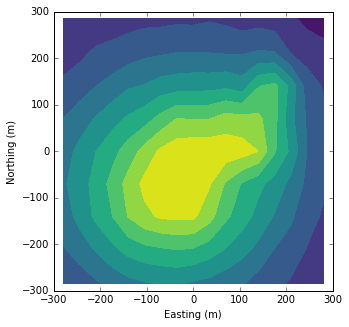

<function __main__.viz>

In [118]:

nx, ny = x.size, y.size
def viz(itime):
    figsize(5,5)
    plt.contourf(xy[:,0].reshape((nx, ny), order="F"), xy[:,1].reshape((nx, ny), order="F"), np.log10(DOBS[itime,:].reshape((nx, ny), order="F")), 10, cmap="viridis")
    xlim(-300, 300)
    ylim(-300, 300)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.show()
interact(viz, itime=(0, 9,1))    

(0.0001, 0.0020000000000000005)

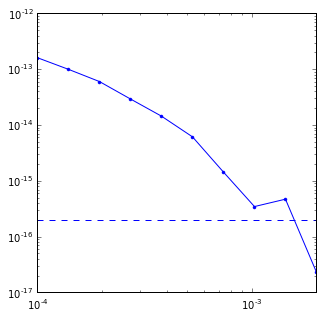

In [119]:
figsize(5,5)
irx = 1
# plt.loglog(times, DATA[:,irx], 'k.')
plt.loglog(times, DOBS[:,irx], 'b.-')
plt.loglog(times, np.ones_like(times)*TKCATEMexample["floor"], 'b--')
plt.xlim(times.min(), times.max())

In [120]:
def vizplan(sigma, indz=21):
    figsize(5,5)
    # mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
    mesh.plotSlice(np.log10(sigma), grid=True, ind=indz, clim=(-4, -1), pcolorOpts={"cmap":"viridis"})
#     plt.plot(xyz[:,0], xyz[:,1], 'r.')
    plt.plot(xyz[::2,0], xyz[::2,1], 'wo', ms=3)
    plt.title(("Elevation at %.1fm")%(mesh.vectorCCz[indz]))
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    xlim(-500, 500)
    ylim(-500, 500)

In [121]:
predmodel = []
for i in range(1,11):
    if i<10:
        temp = np.load("./invresults/00"+str(i)+"-InversionModel-2016-06-28-20-00.npy")
    else:
        temp = np.load("./invresults/0"+str(i)+"-InversionModel-2016-06-28-20-00.npy")
    predmodel.append(temp)

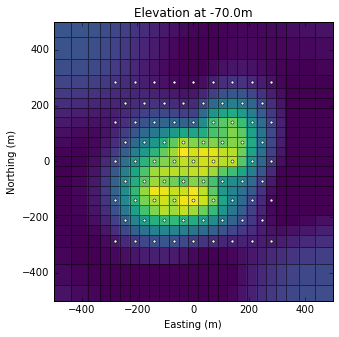

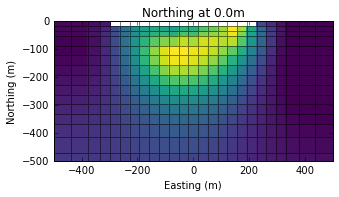

In [122]:
iteration = 9
airind = sigma == 1e-8
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap
sigest = mapping*predmodel[iteration]
sigest[airind] = np.nan
vizplan(sigest)
vizsection(sigest)

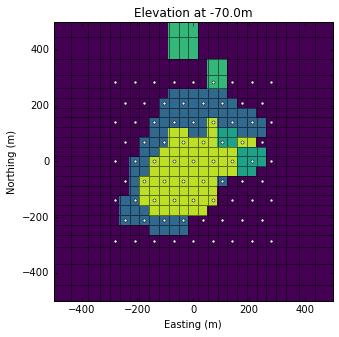

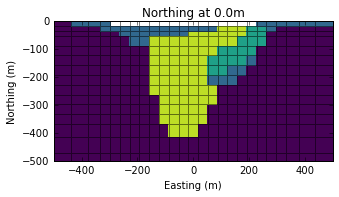

In [123]:
vizplan(sigma_nan)
vizsection(sigma_nan)